# Traffic sign recognition - Nerual Net

In [1]:
import numpy as np
np.random.seed(123)  # for reproducibility

import tensorflow as tf
print(tf.__version__)

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D, MaxPooling2D
from tensorflow.keras import activations

from sklearn import model_selection
from sklearn.utils import shuffle

from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from imageio import imread # Need 'Imageio' 'Pillow' packages
import cv2

from math import floor, ceil

import h5py

2.2.0


# Run this if on Colab

In [2]:
import tensorflow as tf

# Checking GPU support
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  #raise SystemError('GPU device not found')
  print('GPU NOT FOUND!!')
else:
  print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
# Mounting Drive
from google.colab import drive
drive.mount('/content/drive')

# Unzipping the data
!unzip /content/drive/My\ Drive/German\ traffic\ sign\ dataset.zip #-d path_to_directory /content/German_traffic_sign_dataset

## Load data from German traffic sign database

In [4]:
# Use this if local
main_folder_path = "./German traffic sign dataset"
# Use this if Colab
# main_folder_path = "/content/German traffic sign dataset"

train_dataset_path = main_folder_path + "/GTSRB_Training" + "/"

csv_content = [] # One numpy array per folder
                 # Each numpy array x: image y: proprierties

# Iterate over all subfolders to read the CSV file of each class
for i in range(43):
    image_path = train_dataset_path + "{:05.0f}".format(i) + "/"
    f_name = image_path + "GT-" + "{:05.0f}".format(i) + ".csv"
    csv_content.append(np.genfromtxt(f_name, delimiter=';', skip_header=1, dtype=str))
print(csv_content[0][1,:])

['00000_00001.ppm' '30' '30' '5' '5' '25' '25' '0']


In [0]:
# Load the images and respective class

image = []
labels = []

for i in range(43):
    image_class = []
    train_dataset_path = main_folder_path + "/GTSRB_Training" + "/" + "{:05.0f}".format(i) + '/'
    for label_name in enumerate(csv_content[i][:,0]):
        image_class.append(imread(train_dataset_path + label_name[1])[:,:,0]*0.2989+ # Adding image
                           imread(train_dataset_path + label_name[1])[:,:,1]*0.5870+ # with color
                           imread(train_dataset_path + label_name[1])[:,:,2]*0.1140) # adjusted by filtering
    labels.append(i*np.ones(len(image_class))) # Appending image class based on folder
    image.append(image_class)

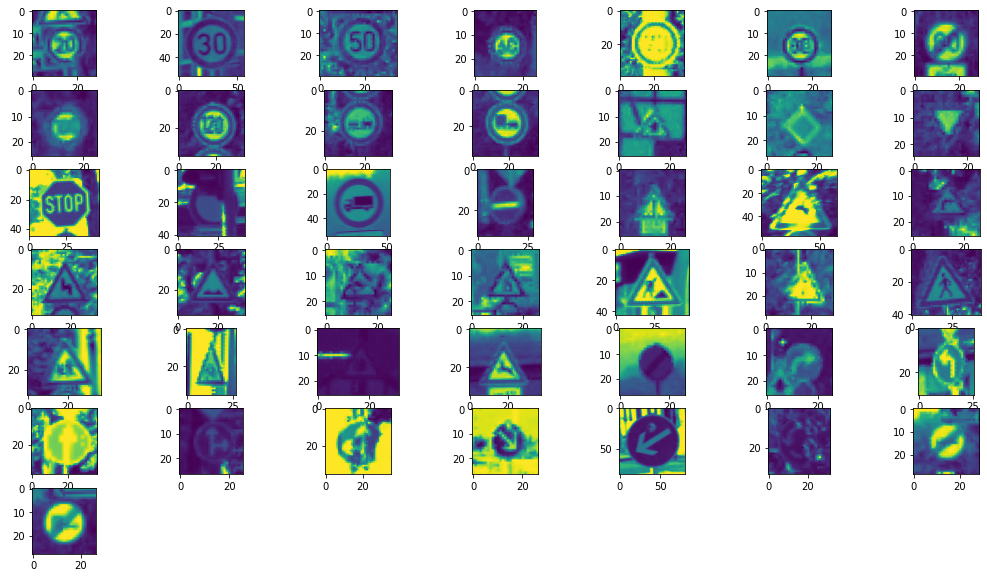

In [6]:
# Print the first image in every class
fig = plt.figure(figsize=(18, 10))
gs = gridspec.GridSpec(nrows=7, ncols=7)

for i in enumerate(image):
    ax0 = fig.add_subplot(gs[i[0]//7, i[0]%7])
    ax0.imshow(i[1][0])
    
plt.show()

<function matplotlib.pyplot.show>

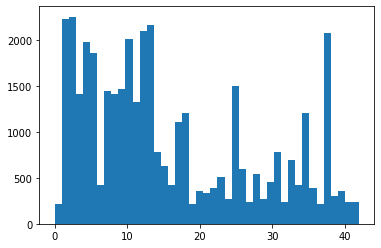

In [7]:
# Histogram of class population
plt.hist(np.concatenate(labels), len(image))
plt.show

## Adapting the images

In [0]:
# Reshape training set
x_size = 32
y_size = 32
img_train = []

for image_set in enumerate(image):
    for image_array in enumerate(image_set[1]):
        # Cutting the image to match the content
        x2 = int(csv_content[image_set[0]][image_array[0], 5]) 
        x1 = int(csv_content[image_set[0]][image_array[0], 3])
        y2 = int(csv_content[image_set[0]][image_array[0], 6]) 
        y1 = int(csv_content[image_set[0]][image_array[0], 4])
        size = max(x2-x1, y2-y1)
        # Padding to have square images
        padded = np.pad(np.asarray(image_array[1][x1:x2, y1:y2]), \
                        ((floor((size-x2+x1)/2), ceil((size-x2+x1)/2)),\
                         (floor((size-y2+y1)/2), ceil((size-y2+y1)/2))))
        # Reshaping the image to match the selected dimension
        reshaped = cv2.resize(padded, (x_size, y_size), interpolation = cv2.INTER_AREA)
        # Copying the image inside the output array
        img_train.append(reshaped)
img_train = np.asarray(img_train)

In [0]:
# Reshaping the train data to have a correct fit input
img_train_rsh = np.reshape(img_train, (img_train.shape[0], img_train.shape[1], img_train.shape[2],1))
labels_flattened = np.concatenate(labels)
x_train, y_train = shuffle(img_train_rsh, labels_flattened)

## Loading test data

In [0]:
# Use this if no test data supplied

# Split train and validation data from the train dataset
#x_train, x_test, y_train, y_test = model_selection.train_test_split(img_train_rsh, labels_flattened, test_size=0.20)
#print(x_train.shape[0], x_test.shape[0], y_train.shape[0], y_test.shape[0])

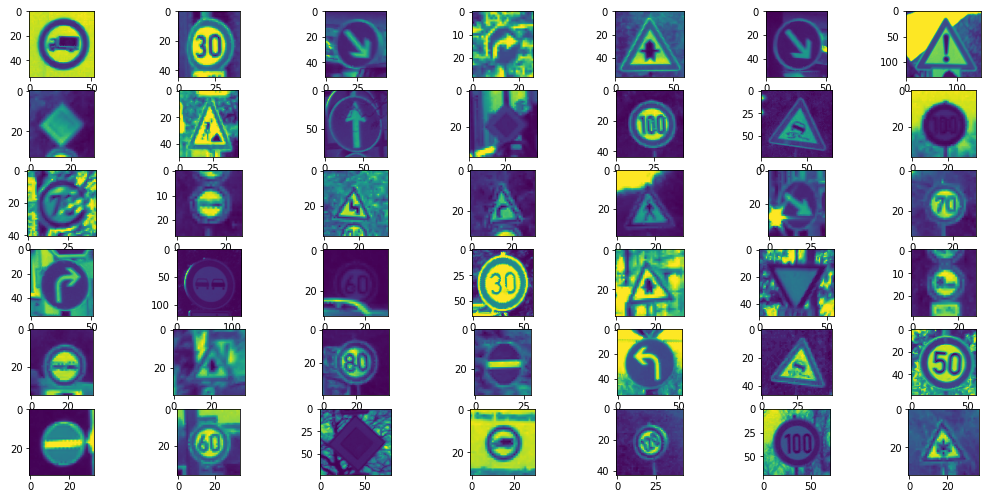

In [11]:
# Run this section if test data are supplied - more image to train classifier
main_folder_path = "./German traffic sign dataset"

# Adapting test data to network input dimension from data dataset
test_dataset_path = main_folder_path + "/GTSRB_Testing"

test_csv = (np.genfromtxt(test_dataset_path  + "/GT-final_test.csv", delimiter=';', skip_header=1, dtype=str))

image_test = []

for name_img in test_csv:
    image_test.append(imread(test_dataset_path + "/" + name_img[0])[:,:,0]*0.2989+
                      imread(test_dataset_path + "/" + name_img[0])[:,:,1]*0.5870+
                      imread(test_dataset_path + "/" + name_img[0])[:,:,2]*0.1140)
    
fig = plt.figure(figsize=(18, 10))
gs = gridspec.GridSpec(nrows=7, ncols=7)

for i in range(42):
    ax0 = fig.add_subplot(gs[i//7, i%7])
    ax0.imshow(image_test[i])

plt.show()       

# Count total number of images:
img_test_num = len(image_test)
                                 
# Reshape test set
img_test = np.empty((img_test_num, x_size, y_size))

for image_set in enumerate(image_test):
    # Cutting the image to match the content
    x2 = int(test_csv[image_set[0], 5]) 
    x1 = int(test_csv[image_set[0], 3])
    y2 = int(test_csv[image_set[0], 6]) 
    y1 = int(test_csv[image_set[0], 4])
    size = max(x2-x1, y2-y1)
    # Padding to have square images
    padded = np.pad(np.asarray(image_set[1][x1:x2, y1:y2]), \
                    ((floor((size-x2+x1)/2), ceil((size-x2+x1)/2)),\
                     (floor((size-y2+y1)/2), ceil((size-y2+y1)/2))))
    # Reshaping the image to match the selected dimension
    reshaped = cv2.resize(padded, (x_size, y_size), interpolation = cv2.INTER_AREA)
    # Copying the image inside the output array
    np.copyto(img_test[image_set[0],:,:], reshaped)

img_test_rsh = np.reshape(img_test, (img_test.shape[0], img_test.shape[1], img_test.shape[2],1))

x_test = img_test_rsh
y_test = test_csv[:, 7].astype(np.int)

In [0]:
# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train = to_categorical(y_train, len(image))
Y_test = to_categorical(y_test, len(image))

In [13]:
print(x_train.shape, x_test.shape, Y_train.shape, Y_test.shape)

(39209, 32, 32, 1) (12630, 32, 32, 1) (39209, 43) (12630, 43)


In [0]:
x_train /= 255
x_test /= 255

#Creating optimized model

In [0]:
model_q = Sequential()
model_q.add(Conv2D(10, (7,7), strides=(1,1), activation='relu', input_shape=(x_size, y_size, 1)))
model_q.add(MaxPool2D(pool_size=(2,2)))
model_q.add(Conv2D(50, (4,4), strides=(1,1), activation='relu'))
model_q.add(MaxPool2D(pool_size=(2,2)))
model_q.add(Conv2D(100, (4,4), strides=(1,1), activation='relu'))
model_q.add(MaxPool2D(pool_size=(2,2)))
model_q.add(Flatten())
model_q.add(Dense(100, activation='relu'))
model_q.add(Dense(43, activation='softmax'))

In [16]:
model_q.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_q.fit(x_train, Y_train, batch_size=50, epochs=10, verbose=1)

Epoch 1/10
785/785 [==============================] - 3s 3ms/step - loss: 1.4648 - accuracy: 0.6225
Epoch 2/10
785/785 [==============================] - 2s 3ms/step - loss: 0.2495 - accuracy: 0.9390
Epoch 3/10
785/785 [==============================] - 2s 3ms/step - loss: 0.1298 - accuracy: 0.9688
Epoch 4/10
785/785 [==============================] - 2s 3ms/step - loss: 0.0855 - accuracy: 0.9795
Epoch 5/10
785/785 [==============================] - 2s 3ms/step - loss: 0.0636 - accuracy: 0.9839
Epoch 6/10
785/785 [==============================] - 2s 3ms/step - loss: 0.0490 - accuracy: 0.9871
Epoch 7/10
785/785 [==============================] - 2s 3ms/step - loss: 0.0437 - accuracy: 0.9882
Epoch 8/10
785/785 [==============================] - 2s 3ms/step - loss: 0.0316 - accuracy: 0.9913
Epoch 9/10
785/785 [==============================] - 2s 3ms/step - loss: 0.0225 - accuracy: 0.9937
Epoch 10/10
785/785 [==============================] - 2s 3ms/step - loss: 0.0280 - accuracy: 0.9914

In [17]:
model_q.save("./model_q.h5")
print("Saved models to disk")

Saved models to disk


#Quantization aware training

In [0]:
def rep_data_gen():
    for i in x_test:
        f = np.reshape(i, (1, 32, 32, 1))
        tensor = tf.convert_to_tensor(f, tf.float32)
        yield [tensor]

In [19]:
!pip install tensorflow_model_optimization
import tensorflow_model_optimization as tfmot

     |████████████████████████████████| 174kB 4.7MB/s 
     |████████████████████████████████| 296kB 14.4MB/s 


In [20]:
# To use with Tensorflow 2

# q_aware stands for for quantization aware.
model_qa = load_model('model_q.h5')
quantize_model = tfmot.quantization.keras.quantize_model
q_aware_model = quantize_model(model_qa)

# `quantize_model` requires a recompile.
q_aware_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

q_aware_model.summary()

q_aware_model.fit(x_train, Y_train, batch_size=50, epochs=1, verbose=1)#, validation_split=0.1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
quant_conv2d (QuantizeWrappe (None, 26, 26, 10)        523       
_________________________________________________________________
quant_max_pooling2d (Quantiz (None, 13, 13, 10)        1         
_________________________________________________________________
quant_conv2d_1 (QuantizeWrap (None, 10, 10, 50)        8153      
_________________________________________________________________
quant_max_pooling2d_1 (Quant (None, 5, 5, 50)          1         
_________________________________________________________________
quant_conv2d_2 (QuantizeWrap (None, 2, 2, 100)         80303     
_________________________________________________________________
quant_max_pooling2d_2 (Quant (None, 1, 1, 100)         1         
_________________________________________________________________
quant_flatten (QuantizeWrapp (None, 100)               1

In [21]:
q_aware_model.save("/content/model_qa.h5")
print("Saved model to disk")

Saved model to disk


In [0]:
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)#_file("/content/model_qa.h5")
converter.representative_dataset = rep_data_gen
converter.target_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

quant_model = converter.convert()

##Exporting quantization-aware training model

In [23]:
open ("/content/model_qa.tflite" , "wb") .write(quant_model)

417320